In [110]:
# %matplotlib inline
import os
from pprint import pprint
import pickle
from collections import Counter
import statistics as stat
import pandas as pd 
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import scale
from scipy.sparse.linalg import eigs
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2grey
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(0)

# plt.rcParams['figure.figsize'] = [4, 4]
sns.set(style = "darkgrid")

%run fns.ipynb
%run visualize.ipynb

In [111]:
path = os.getcwd() + '/dataset/Face_data/'
data = collect_images(path)
data = data.astype(np.float)

/home/mayank/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [112]:
""" Randomly split data, to get train and test set """
a = 70
K = 5

data[:,-1] = data[:,-1] - 1

np.random.shuffle(data)
no_rows = randomSplitDataset(data.shape[0], a)

train_data = data[0:no_rows, :]
req_no_of_rows = makeSplit(train_data.shape[0], K) # should be divisble by K for Cross Valid.
train_data = train_data[0:req_no_of_rows, :]  

test_data = data[req_no_of_rows:, :]
no_of_classes = 11

print('Total data: ', data.shape)
print('Train data: ', train_data.shape, ' Test data: ', test_data.shape)

Total data:  (710, 2017)
Train data:  (495, 2017)  Test data:  (215, 2017)


In [113]:
# viewImg(np.reshape(train_data[2,:-1], (48,42)), True)  # To show data point

In [114]:
""" Classifying the original dataset as it is. """
classify(train_data, test_data)

Accuracy:  0.586046511627907


Mean of accuracy:  0.802020202020202 Standard deviation of accuracy:  0.06407576374607554
Accuracy using best model on Test set:  0.7767441860465116


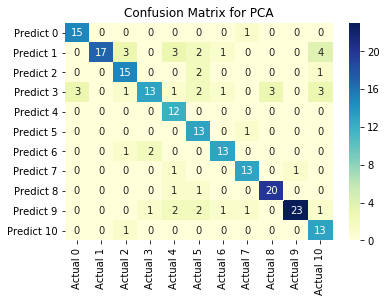

In [135]:
""" PCA """

# eigen_energy = [0.95, 0.99, 0.90, 0.70]
eigen_energy = [0.95]

for eg in eigen_energy:
    pca_train, projection_mat = pca(train_data[:, :-1], eg) # don't send class lables
    pca_train = pca_train.real

    pca_test = np.dot(projection_mat, test_data[:, :-1].T).T
    pca_test = pca_test.real

    pca_train = np.append(pca_train, train_data[:,-1][:,np.newaxis], axis = 1)
    pca_test = np.append(pca_test, test_data[:,-1][:,np.newaxis], axis = 1)

    selected_model = crossValidation(pca_train, K) # returns best model
    confusion_mat = classifyTestset(selected_model, pca_test)
    drawConfusionMatrix(confusion_mat, 'PCA')

In [136]:
# eigenFaces(projection_mat.real)
projection_mat.shape

(25, 2016)

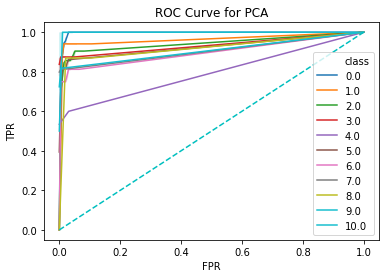

In [117]:
""" ROC on PCA Test data """
prb = selected_model.predict_proba(pca_test[:,:-1])
ROC(pca_test, prb, 'PCA')

Mean of accuracy:  1.0 Standard deviation of accuracy:  0.0
Accuracy using best model on Test set:  0.13488372093023257


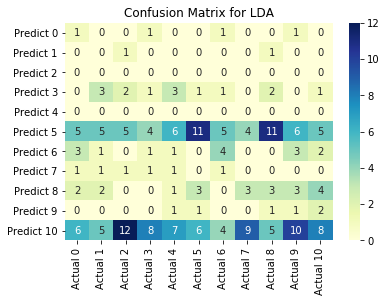

In [118]:
""" LDA """

lda_train, projection_matrix = LDA(train_data)
lda_train = lda_train.real

lda_test = np.dot(projection_matrix, test_data[:,:-1].T).T  
lda_test = lda_test.real

lda_test = np.append(lda_test, test_data[:,-1][:,np.newaxis], axis = 1)
best_model = crossValidation(lda_train, K)

confusion_matrix = classifyTestset(best_model, lda_test)
drawConfusionMatrix(confusion_matrix, 'LDA')

In [133]:
print(lda_test.shape)
print(lda_train.shape)

(215, 11)
(495, 11)


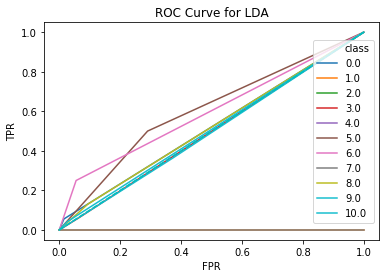

In [120]:
""" ROC on LDA Test data """
prb = best_model.predict_proba(lda_test[:,:-1])
ROC(lda_test, prb, 'LDA')

In [121]:
""" LDA on PCA projected data """
lda_pca_train, pr_mat1 = LDA(pca_train)
lda_pca_train = lda_pca_train.real

lda_pca_test = np.dot(pr_mat1, pca_test[:,:-1].T).T  
lda_pca_test = lda_pca_test.real

lda_pca_test = np.append(lda_pca_test, pca_test[:,-1][:,np.newaxis], axis = 1)

classify(lda_pca_train, lda_pca_test)

Accuracy:  0.9162790697674419


In [122]:
""" PCA on LDA projected data """
pca_lda_train, pr_mat2 = pca(lda_train[:,:-1], 1)
pca_lda_train = pca_lda_train.real

pca_lda_test = np.dot(pr_mat2, lda_test[:,:-1].T).T  
pca_lda_test = pca_lda_test.real

pca_lda_train = np.append(pca_lda_train, lda_train[:,-1][:,np.newaxis], axis =1) # pca function doesn't return labels
pca_lda_test = np.append(pca_lda_test, lda_test[:,-1][:,np.newaxis], axis = 1)

classify(pca_lda_train, pca_lda_test)

Accuracy:  0.13488372093023257
